In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Bidirectional, Dropout
from tensorflow.keras.optimizers.legacy import Adam as LegacyAdamfrom 
from tensorflow.keras.regularizers import l1_l2
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import nltk

In [4]:
df=pd.read_csv('train.csv')

In [5]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


### Preprocessing and Feature Engineering

In [6]:
df["text"] = df["title"] + " " + df["text"]

In [7]:
df.dropna(subset=['text'], inplace=True)

In [8]:
df.drop(columns=['id', 'author', 'title'], inplace=True)

In [9]:
df.head()

,text,label
0,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",0
2,Why the Truth Might Get You Fired Why the Trut...,1
3,15 Civilians Killed In Single US Airstrike Hav...,1
4,Iranian woman jailed for fictional unpublished...,1


In [3]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

In [10]:
# Define a function
def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = text.split()
    # Remove stop words and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    return tokens

In [11]:
# Apply preprocessing to each text in the dataframe
df['clean_text'] = df['text'].apply(preprocess_text)

In [12]:
df['clean_text'][0]

['house',
 'dem',
 'aide',
 'didnt',
 'even',
 'see',
 'comeys',
 'letter',
 'jason',
 'chaffetz',
 'tweeted',
 'house',
 'dem',
 'aide',
 'didnt',
 'even',
 'see',
 'comeys',
 'letter',
 'jason',
 'chaffetz',
 'tweeted',
 'darrell',
 'lucus',
 'october',
 'subscribe',
 'jason',
 'chaffetz',
 'stump',
 'american',
 'fork',
 'utah',
 'image',
 'courtesy',
 'michael',
 'jolley',
 'available',
 'creative',
 'commonsby',
 'license',
 'apology',
 'keith',
 'olbermann',
 'doubt',
 'worst',
 'person',
 'world',
 'weekfbi',
 'director',
 'james',
 'comey',
 'according',
 'house',
 'democratic',
 'aide',
 'look',
 'like',
 'also',
 'know',
 'secondworst',
 'person',
 'well',
 'turn',
 'comey',
 'sent',
 'nowinfamous',
 'letter',
 'announcing',
 'fbi',
 'looking',
 'email',
 'may',
 'related',
 'hillary',
 'clinton',
 'email',
 'server',
 'ranking',
 'democrat',
 'relevant',
 'committee',
 'didnt',
 'hear',
 'comey',
 'found',
 'via',
 'tweet',
 'one',
 'republican',
 'committee',
 'chairman',
 

### Word Embedding

In [18]:
# Train Word2Vec model
word2vec_model = Word2Vec(sentences=df['clean_text'],
                          vector_size=100,
                          window=5,
                          min_count=1,
                          workers=4)

In [21]:
#sample
word2vec_model.wv.most_similar('cook')

[('steak', 0.7322383522987366),
 ('chicken', 0.6927421689033508),
 ('chef', 0.6858146786689758),
 ('dessert', 0.6839103698730469),
 ('pizza', 0.6832273006439209),
 ('recipe', 0.6826137900352478),
 ('meal', 0.6819060444831848),
 ('cheese', 0.681879997253418),
 ('coffee', 0.6780673861503601),
 ('bagel', 0.6772254109382629)]

### Tokenization

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])

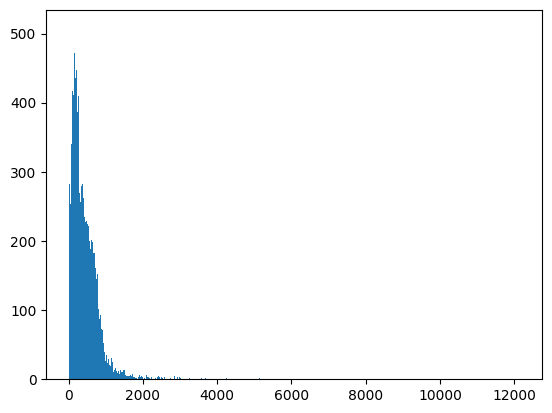

In [60]:
plt.hist([len(word) for word in sequences], bins=1000)
plt.show()

In [17]:
# Pad sequences to ensure uniform length
max_sequence_length = 1000
data = pad_sequences(sequences, maxlen=max_sequence_length)

In [ ]:
vocab_size = len(word_index) + 1

In [22]:
# Prepare the embedding matrix
word_index = tokenizer.word_index
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

In [43]:
embedding_matrix.shape

(165366, 100)

### Train Test Split

In [25]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, df['label'], test_size=0.3, random_state=42)

### Model Building

In [44]:
# Define the LSTM model with regularization and a bidirectional layer
model = Sequential()
model.add(Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
model.add(Bidirectional(LSTM(128, return_sequences=False, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

In [46]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 100)         16536600  
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               234496    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16771353 (63.98 MB)
Trainable params: 234753 (917.00 KB)
Non-trainable params: 16536600 (63.08 MB)
_________________________________________________________________


In [47]:
from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam

In [48]:
# Compile the model with hyperparameter tuning
model.compile(loss='binary_crossentropy',
              optimizer=LegacyAdam(learning_rate=0.001),
              metrics=['accuracy'])

In [49]:
# Train the model with early stopping and a validation set
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [50]:
history = model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=10,
          batch_size=64,
          callbacks=[early_stopping])

Epoch 1/10
221/221 [==============================] - 367s 2s/step - loss: 0.3814 - accuracy: 0.8683 - val_loss: 0.2601 - val_accuracy: 0.9225
Epoch 2/10
221/221 [==============================] - 535s 2s/step - loss: 0.2628 - accuracy: 0.9188 - val_loss: 0.2400 - val_accuracy: 0.9254
Epoch 3/10
221/221 [==============================] - 406s 2s/step - loss: 0.2612 - accuracy: 0.9159 - val_loss: 0.2854 - val_accuracy: 0.9063
Epoch 4/10
221/221 [==============================] - 402s 2s/step - loss: 0.2252 - accuracy: 0.9332 - val_loss: 0.2117 - val_accuracy: 0.9378
Epoch 5/10
221/221 [==============================] - 410s 2s/step - loss: 0.1757 - accuracy: 0.9507 - val_loss: 0.1680 - val_accuracy: 0.9569
Epoch 6/10
221/221 [==============================] - 378s 2s/step - loss: 0.1326 - accuracy: 0.9680 - val_loss: 0.1417 - val_accuracy: 0.9682
Epoch 7/10
221/221 [==============================] - 367s 2s/step - loss: 0.1170 - accuracy: 0.9735 - val_loss: 0.1489 - val_accuracy: 0.9611

### Evaluate and Validate

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


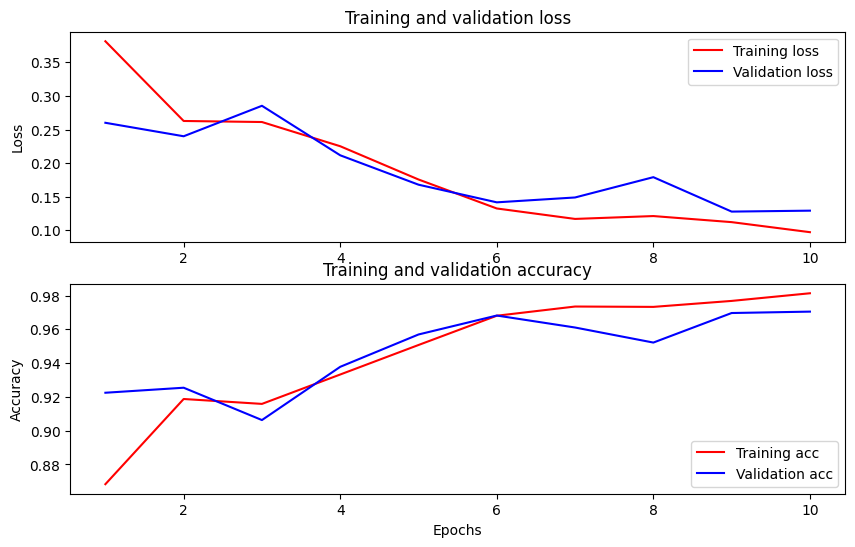

In [51]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [52]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

190/190 [==============================] - 73s 386ms/step - loss: 0.1293 - accuracy: 0.9705
Test Accuracy: 0.9704669117927551


In [53]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [54]:
# Predict the values from the test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

190/190 [==============================] - 67s 349ms/step


In [55]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
cm

array([[3005,  124],
       [  55, 2877]])

In [56]:
# Print the classification report
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3129
           1       0.96      0.98      0.97      2932

    accuracy                           0.97      6061
   macro avg       0.97      0.97      0.97      6061
weighted avg       0.97      0.97      0.97      6061



### Saved Model

In [27]:
from tensorflow.keras.models import save_model

In [ ]:
model.save('lstm_model.h5')

<h2 style="text-align: center;">The End</h2>

### Kaggel Submission

In [2]:
test=pd.read_csv('test.csv')

In [3]:
submission=pd.read_csv('submit.csv')

In [4]:
test.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [5]:
test["text"] = test["title"] + " " + test["text"]

In [6]:
def fill_data(data):
    data["title"] = data["title"].fillna("No Title")
    data["text"] = data["text"].fillna("No text")
    return data

In [7]:
test = fill_data(test)

In [8]:
test.drop(columns=['id', 'author', 'title'], inplace=True)

In [9]:
test.head()

,text
0,"Specter of Trump Loosens Tongues, if Not Purse..."
1,Russian warships ready to strike terrorists ne...
2,#NoDAPL: Native American Leaders Vow to Stay A...
3,"Tim Tebow Will Attempt Another Comeback, This ..."
4,Keiser Report: Meme Wars (E995) 42 mins ago 1 ...


In [10]:
df =test.copy()

In [11]:
lemmatizer = WordNetLemmatizer()

In [12]:
# Define a function for cleaning and preprocessing text
def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize
    tokens = text.split()
    # Remove stop words and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    return tokens

df['clean_text'] = df['text'].apply(preprocess_text)

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])

# Pad sequences to ensure uniform length
max_sequence_length = 1000
data = pad_sequences(sequences, maxlen=max_sequence_length)

### Load Model

In [16]:
from tensorflow.keras.models import load_model

In [17]:
model = load_model('lstm_model.h5')

In [18]:
prediction = model.predict(data)

163/163 [==============================] - 57s 347ms/step


In [ ]:
# Predict the values from the test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

In [20]:
y_predicted = prediction.flatten()

In [21]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 1, ..., 1, 1, 0])

In [22]:
submission["label_2"] = y_predicted

In [26]:
submission.head(5)

,id,label,label_2
0,20800,0,0
1,20801,1,1
2,20802,0,1
3,20803,1,1
4,20804,1,1
